<IPython.core.display.Javascript object>


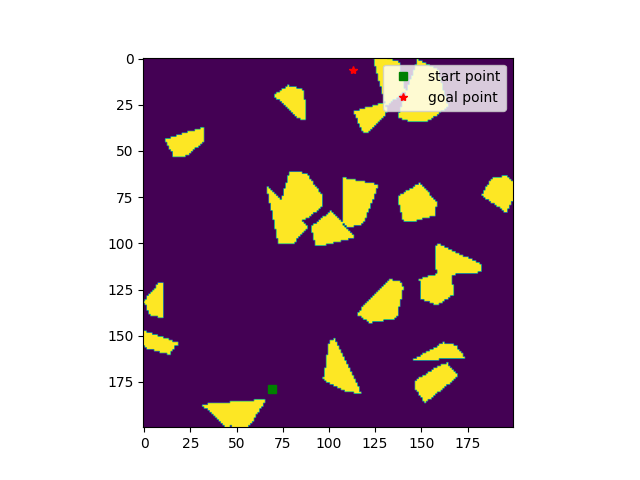

<IPython.core.display.Javascript object>


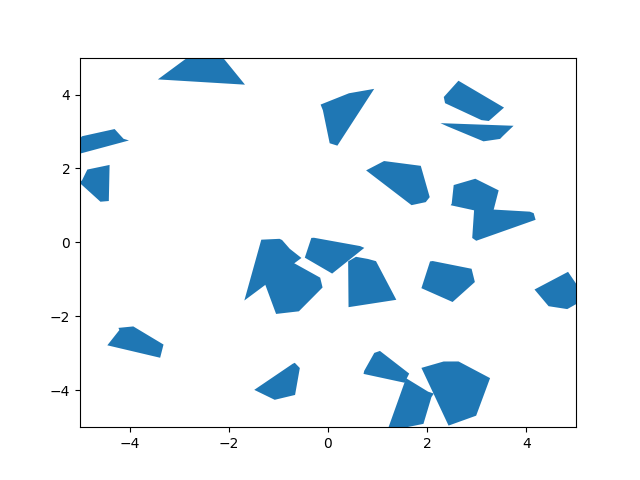

<IPython.core.display.Javascript object>


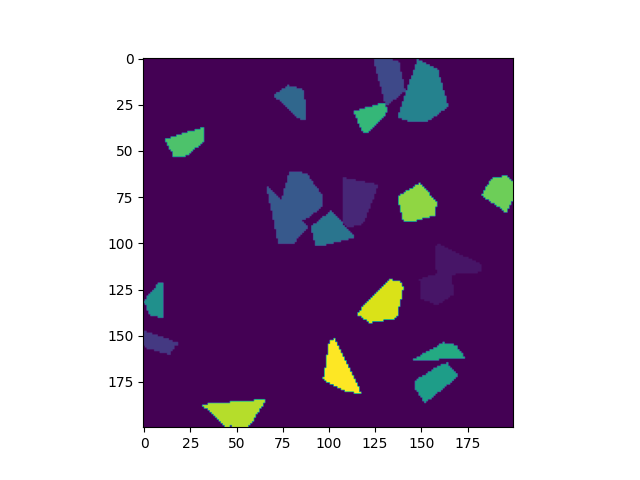

In [81]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
# plt.rcParams['figure.figsize'] = [10, 5]
import heapq
import cv2
import time

def make_poly(x, y, r, n):
    """Make a convex polygon centered at (x,y) """
    ts = np.sort(np.random.uniform(0, 2*np.pi, n))
    rs = np.random.uniform(r*0.9, r*1.1, n)

    pts = np.array([rs*np.cos(ts) + x, rs*np.sin(ts) + y]).T

    poly = plt.Polygon(pts)
    return poly

def generate_random_obstacles(n, obs_type, start_pt, goal_pt):
    sigma = 2
    obstacles = []
    for i in range(n):
        x = np.random.uniform(-5,5)
        y = np.random.uniform(-5,5)
        r = np.random.uniform(0.5, 1)
        if obs_type == "circles":
            patch = plt.Circle([x, y], r)
        elif obs_type == "polygons":
            patch = make_poly(x, y, r, 6)
        else:
            raise RuntimeError("Valid obstacle types are 'circles' or 'polygons'")
        while patch.contains_point(start_pt) or patch.contains_point(goal_pt):
            x = np.random.uniform(-5,5)
            y = np.random.uniform(-5,5)
            r = np.random.uniform(0.5, 1)
            if obs_type == "circles":
                patch = plt.Circle([x, y], r)
            elif obs_type == "polygons":
                patch = make_poly(x, y, r, 6)
        obstacles.append(patch)
    return obstacles

def convert_obstacles_to_image(obstacles, img_shape, start_pt, goal_pt):
    img = -1*np.ones(img_shape)
    obs_index_img = -1*np.ones(img_shape,dtype="int")
    xmin = -5
    xmax = 5
    xs = np.linspace(xmin, xmax, img_shape[1])
    ymin = xmin*img_shape[0]/img_shape[1]
    ymax = xmax*img_shape[0]/img_shape[1]
    ys = np.linspace(ymin, ymax, img_shape[0])
    
    max_obs_index = 0
    
    all_obs_pts = [[]]

    for obs in obstacles:
        obs_index = max_obs_index
        extent = obs.get_window_extent()
        imin = int((min(max(xmin, extent.x0), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        imax = int((min(max(xmin, extent.x1), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        jmin = int((min(max(ymin, extent.y0), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        jmax = int((min(max(ymin, extent.y1), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        obs_pts = []
        for i in range(imin, imax):
            for j in range(jmin, jmax):
                if obs.contains_point([xs[i], ys[j]]):
                    img[j, i] = 0
                    obs_pts.append([i,j])
                    if obs_index_img[j,i] != -1:
                        obs_index = obs_index_img[j,i]
        if obs_index == max_obs_index:
            max_obs_index += 1
            all_obs_pts.append([])
        
        for i,j in obs_pts:
            obs_index_img[j,i] = obs_index
        all_obs_pts[obs_index] += obs_pts
                    
    A = np.array([[img_shape[1]/(xmax-xmin), 0],
                  [0, img_shape[0]/(ymax-ymin)]])
    xscale = img_shape[1]/(xmax-xmin)
    yscale = img_shape[0]/(ymax-ymin)
    new_start = np.array(
        [(start_pt[0]-xmin)*xscale, (start_pt[1]-ymin)*yscale], dtype='int')
    img[new_start[1],new_start[0]] = -1
    new_goal = np.array(
        [(goal_pt[0]-xmin)*xscale, (goal_pt[1]-ymin)*yscale], dtype='int')
    img[new_goal[1], new_goal[0]] = -1
    return img, all_obs_pts, new_start, new_goal

def create_map(num_obstacles, obstacle_type, map_size):
    global obstacles
    start_pt = np.array([-3, 3])
    goal_pt = np.array([3, -3])
    start_pt = np.random.uniform([-5, -5], [0, 5], 2)
    goal_pt = np.random.uniform([0, -5], [5, 5], 2)
    obstacles = generate_random_obstacles(
        num_obstacles, obstacle_type, start_pt, goal_pt)
    img, all_obs_pts, img_start_pt, img_goal_pt = convert_obstacles_to_image(
        obstacles, (map_size, map_size), start_pt, goal_pt)
    return img, all_obs_pts, img_start_pt, img_goal_pt

img, all_obs_pts, img_start_pt, img_goal_pt = create_map(20, "polygons", 200)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs', label='start point')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*', label='goal point')
plt.legend()

fig, ax = plt.subplots()
for obs in obstacles:
    ax.add_patch(obs)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

obs_img = -1*np.ones_like(img)
for i, obs_pts in enumerate(all_obs_pts):
    for pt in obs_pts:
        obs_img[pt[1],pt[0]] = i
plt.figure()
plt.imshow(obs_img)

The first task is to find disjoint sets that represent different obstacles. When we converted to the image

[[0, 0], [1, 0], [2, 0], [0, 1], [0, 2]]
[[1, 0], [0, 1]]


<IPython.core.display.Javascript object>


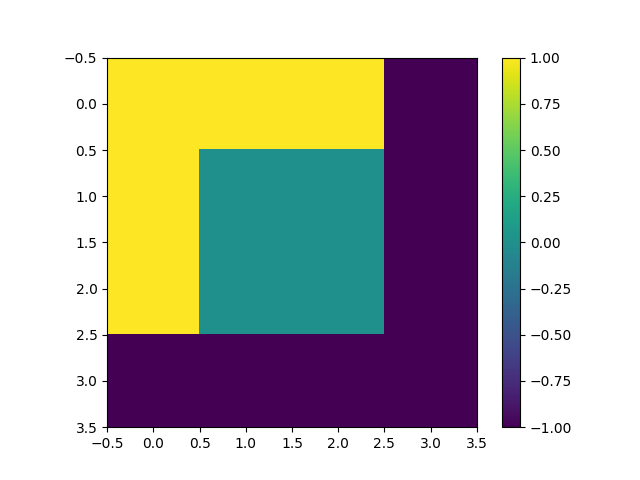

In [92]:
pairs = [[-1, -1], [0, -1], [1, -1], [-1, 0], [1, 0], [-1, 1], [0, 1], [1, 1]]

test_img = np.array(
[
    [-1,-1,-1,-1],
    [-1,0,0,-1],
    [-1,0,0,-1],
    [-1,-1,-1,-1]
])

def find_empty_neighbors(img, pt):
    empty_neighbors = []
    for pair in pairs:
        a = pt[0] + pair[0]
        b = pt[1] + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0] and img[b,a] == -1:
            empty_neighbors.append([a,b])
    return empty_neighbors

def test_empty_neighbors():
    empty_neighbors = find_empty_neighbors(test_img, [1,1])
    print(empty_neighbors)
    
    empty_neighbors = find_empty_neighbors(test_img, [0,0])
    print(empty_neighbors)

test_empty_neighbors()

def color_empty_neighbors(img, empty_neighbors, level):
    for neighbor in empty_neighbors:
        img[neighbor[1],neighbor[0]] = level
    return img

def test_color_neighbors():
    empty_neighbors = find_empty_neighbors(test_img, [1,1])
    new_img = color_empty_neighbors(test_img, empty_neighbors, 1)
    plt.figure()
    plt.imshow(new_img)
    plt.colorbar()

test_color_neighbors()
def brushfire(img, obs_img, all_obs_pts):
    img = img.copy()
    obs_img = -1*np.ones_like(img)
    finished = False
    level_idx = 0
    levels = []
    levels.append(all_obs_pts)
    while not finished:
        finished = True
        level = levels[level_idx]
        next_level = []
        for obs_idx, curr_ring in enumerate(level):
            next_ring = []
            for pt in curr_ring:
                empty_neighbors = find_empty_neighbors(img, pt)
                if len(empty_neighbors) > 0:
                    finished = False
                img = color_empty_neighbors(img, empty_neighbors, level_idx+1)
                obs_img = color_empty_neighbors(obs_img, empty_neighbors, obs_idx)
                next_ring = next_ring + empty_neighbors
            next_level.append(next_ring)
        levels.append(next_level)
        level_idx += 1
    return img, obs_img

<IPython.core.display.Javascript object>


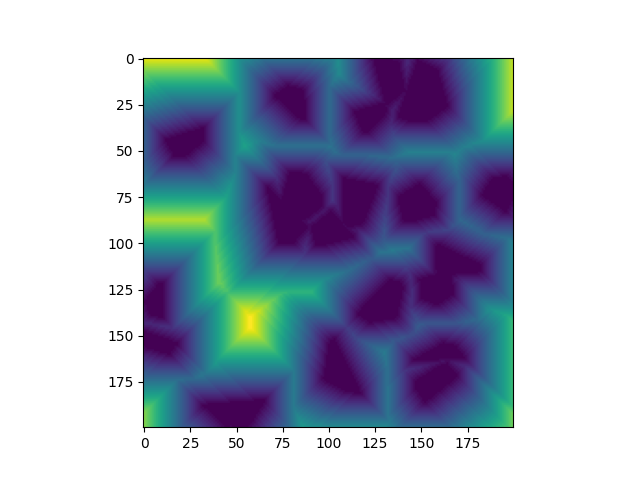

<IPython.core.display.Javascript object>


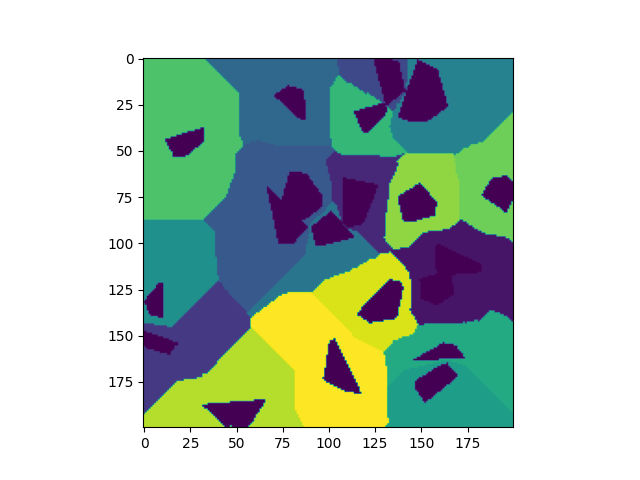

In [93]:
img_done, obs_img_done = brushfire(img, obs_img, all_obs_pts)

plt.figure()
plt.imshow(img_done)

plt.figure()
plt.imshow(obs_img_done)
    
    